### Tasks:
1. **Environment setup**
2. **Data preparation**
4. **Model Building**
6. **Model Evaluation**


## Environment setup

In [47]:
# Importing Libraries
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import re
import string
import time
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.layers import Layer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,Conv1D, Bidirectional, LSTM,Dropout,Input,Embedding,TextVectorization)
from keras.preprocessing.text import one_hot, Tokenizer
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

### Local setup

In [48]:
from keras_preprocessing.sequence import pad_sequences

# Local Path
# root_path = "/Users/loc/Desktop/Git/23mse43006/7.ML/FinalAssignment/application/models/sentiment_analysic/"

# CUONG: Local Path
root_path = "C:/Users/ADMIN/Desktop/sentiment_detect/application/models/sentiment_analysic/"

### Google Colab

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#  Google Drive Path
root_path = "/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/"

Mounted at /content/drive


In [49]:
data_path = root_path + "data_set/"
checkpoint_filepath = root_path + "check_points/"
embeddings = root_path + "embeddings/"
saved_model_path = root_path + "output/"

## Data preparation


### Load IMDb dataset(50,000 records)


In [50]:
movie_reviews = pd.read_csv(data_path + "imdb_dataset_50k.csv")

### Explore the dataset

In [51]:
# Check the shape of the dataset
movie_reviews.shape

(50000, 2)

In [52]:
# Check for missing values
movie_reviews.isnull().sum()

review       0
sentiment    0
dtype: int64

In [53]:
# remove duplicate in review column
movie_reviews.drop_duplicates(subset=['review'], inplace=True)

In [54]:
# Check the shape of the dataset
movie_reviews.shape

(49582, 2)

In [55]:
# Display the first 5 rows of the dataset
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<Axes: xlabel='sentiment', ylabel='count'>

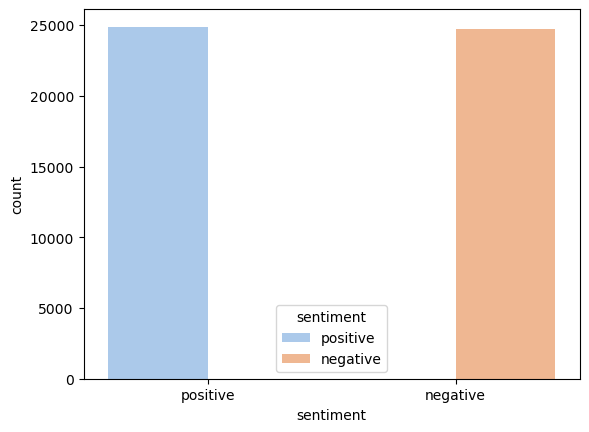

In [56]:
# Plot the count of each sentiment
# sns.countplot(x='sentiment', data=movie_reviews, hue='sentiment', palette='pastel', legend=False)

# CUONG: Plot the count of each sentiment
sns.countplot(x='sentiment', data=movie_reviews, hue='sentiment', palette='pastel')
# plt.legend([],[], frameon=False)

### Convert the sentiment column to binary

In [57]:
# Convert the sentiment column to binary
# movie_reviews['sentiment'] = movie_reviews['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
movie_reviews['sentiment'] = movie_reviews['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).astype(float)

AttributeError: 'numpy.float64' object has no attribute 'startswith'

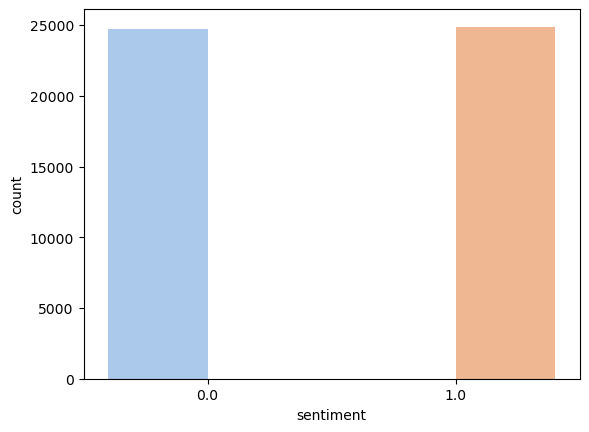

In [58]:
# Plot the count of each sentiment
# sns.countplot(x='sentiment', data=movie_reviews, hue='sentiment', palette='pastel', legend=False)

# Plot the count of each sentiment
# movie_reviews['sentiment'] = movie_reviews['sentiment'].astype(str)
sns.countplot(x='sentiment', data=movie_reviews, hue='sentiment', palette='pastel')
# plt.legend([],[], frameon=False)

### Split the dataset into training, validation, and test sets

In [59]:
# 1. Split according to the common ratio:

# 	•	Training set: 70% (35,000 records)
# 	•	Validation set: 15% (7,500 records)
# 	•	Test set: 15% (7,500 records)

train_data, temp_data = train_test_split(movie_reviews, test_size=0.3, random_state=42)

val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Separate the features (reviews) and labels (sentiments) for each set
X_train, y_train = train_data['review'], train_data['sentiment']
X_val, y_val = val_data['review'], val_data['sentiment']
X_test, y_test = test_data['review'], test_data['sentiment']

## Preparing embedding layer

### Manual

In [60]:
# word_tokenizer = Tokenizer()
# word_tokenizer.fit_on_texts(X_train) # create a dictionary

# X_train = word_tokenizer.texts_to_sequences(X_train) # match the words in the dictionary to the words in the sentences
# X_test = word_tokenizer.texts_to_sequences(X_test)
# len(word_tokenizer.word_index)
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

# vocab_length = len(word_tokenizer.word_index) + 1

# vocab_length
# len(X_train)
# for i in range(10):
#     print(len(X_train[i]))
# Padding all reviews to fixed length 100

# maxlen = 100

# X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
# X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
# len(X_train)
# for i in range(10):
#     print(X_train)

### Keras TextVectorization

#### Standardize data

In [61]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [62]:
import unicodedata

# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

# Convert the stopwords to a TensorFlow constant
stopwords_tensor = tf.constant(list(stop_words))

def remove_stopwords(sentence):
    words = tf.strings.split(sentence)
    filtered_words = tf.boolean_mask(words, tf.math.logical_not(tf.reduce_any(tf.equal(words[:, None], stopwords_tensor[None, :]), axis=1)))
    sentence = tf.strings.reduce_join(filtered_words, separator=' ')
    return sentence

def standardization(sen):

    lowercase = tf.strings.lower(sen)

    # Remove punctuations and numbers
    sentence = tf.strings.regex_replace(lowercase, '[^a-z]', ' ')

    # Take off of html tag
    sentence = tf.strings.regex_replace(sentence, '<[^>]+>', ' ')

    # Single character removal
    sentence = tf.strings.regex_replace(sentence, r'\b\w\b', ' ')

    # Remove multiple spaces
    sentence = tf.strings.regex_replace(sentence, ' +', ' ')

    # Remove head and tail spaces
    sentence = tf.strings.strip(sentence)

    # Remove stopwords #FIXME
    # sentence = remove_stopwords(sentence)

    # Normalize UTF-8 and remove accented characters using standard Python libraries #FIXME
    # def normalize_and_remove_accents(text):
    #     text = unicodedata.normalize('NFKD', text.numpy().decode('utf-8'))
    #     return ''.join(c for c in text if unicodedata.category(c) != 'Mn')

    # sentence = tf.py_function(normalize_and_remove_accents, [sentence], tf.string)

    return sentence

In [63]:
# movie_reviews['review'][2]
# Example usage
sentence = tf.constant("lộc This is a sample sentence, showing off the stop words filtration.")
standardization(sentence)
standardization(movie_reviews['review'][2])

<tf.Tensor: shape=(), dtype=string, numpy=b'thought this was wonderful way to spend time on too hot summer weekend sitting in the air conditioned theater and watching light hearted comedy the plot is simplistic but the dialogue is witty and the characters are likable even the well bread suspected serial killer while some may be disappointed when they realize this is not match point risk addiction thought it was proof that woody allen is still fully in control of the style many of us have grown to love br br this was the most laughed at one of woody comedies in years dare say decade while ve never been impressed with scarlet johanson in this she managed to tone down her sexy image and jumped right into average but spirited young woman br br this may not be the crown jewel of his career but it was wittier than devil wears prada and more interesting than superman great comedy to go see with friends'>

#### **TextVectorization: tokenization, vectorization, and building vocabulary**

In [64]:
# Define hyperparameters
# 1. Batch size for training and validation (64)
BATCH_SIZE=64
# 2. Maximum vocabulary size (10,000)
VOCAB_SIZE=10000
# 3. Maximum sequence length to pad the sentences to (250)
SEQUENCE_LENGTH=250

# Create a TextVectorization layer to vectorize and standardize text data for the model
# Include tokenization, standardization, and vectorization in one layer
vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [65]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))

print("Building the dictionary...")

start_time = time.time()

# Only extract the train from the dataset
vectorize_layer.adapt(train_data.map(lambda train, label: train))

end_time = time.time()

print("Time taken to build the dictionary: ", end_time - start_time)


Building the dictionary...
Time taken to build the dictionary:  14.232533931732178


In [66]:
# print 4 first records of X_val
for i in range(4):
    print(X_val.iloc[i])

I watched the DVD (called BLACK WIDOW in the U.S.A.) and felt afterward that it was, indeed, a truly awful movie. But they must have cut quite a bit out of the original film, or I missed a lot. The sex scenes had very little vulgarity and no nudity (not even a breast), but I've read several other comments on IMDb.com mentioning the vulgarity and something about a tampon. I did not see anything like that, just a bad, boring film with unlikable characters and a trite, sophomoric plot. Giada Colagrande is either paralyzed from the mouth up or Botoxed to the gills, and nary an expression touches her face. And her name makes me think of super-sizing a beverage at Taco Bell: "I'll have the Cola Grande!" It was actually kind of fun it was so bad, I got to play like I was in my own Mystery Science Theater 3000, noting things like the fact that Dafoe's skin is too big for his face. It's really like silly putty!
Dreadful! A friend of mine (who obviously thought I had an abysmal sense of humour) 

In [67]:
# Display the words in the vocabulary with their vector representations
# for i in range(1):
#     print(X_train[i])
#     print(vectorize_layer(X_val[i]))

# print X_val
for i in range(1):
    print(X_val.iloc[i])
    print(vectorize_layer(X_val.iloc[i]))

I watched the DVD (called BLACK WIDOW in the U.S.A.) and felt afterward that it was, indeed, a truly awful movie. But they must have cut quite a bit out of the original film, or I missed a lot. The sex scenes had very little vulgarity and no nudity (not even a breast), but I've read several other comments on IMDb.com mentioning the vulgarity and something about a tampon. I did not see anything like that, just a bad, boring film with unlikable characters and a trite, sophomoric plot. Giada Colagrande is either paralyzed from the mouth up or Botoxed to the gills, and nary an expression touches her face. And her name makes me think of super-sizing a beverage at Taco Bell: "I'll have the Cola Grande!" It was actually kind of fun it was so bad, I got to play like I was in my own Mystery Science Theater 3000, noting things like the fact that Dafoe's skin is too big for his face. It's really like silly putty!
tf.Tensor(
[ 287    2  254  418  314 4043    9    2    3  442 5638   11    8   12
  

In [68]:
vectorize_layer.get_vocabulary()[22]

'he'

In [69]:
print("Starting vectorization...")

def vectorizer(review, label):
    return vectorize_layer(review),label

start_time = time.time()

train_dataset = train_data.map(lambda x, y: (vectorize_layer(x), y))
val_dataset = val_data.map(lambda x, y: (vectorize_layer(x), y))

end_time = time.time()

print("Time taken to vectorize the dataset: ", end_time - start_time)

Starting vectorization...
Time taken to vectorize the dataset:  0.11499714851379395


## Models Training:

### **Simple RNN:**

#### **Build the model**

In [70]:
# Define hyperparameters
# 1. Batch size for training and validation (64)
BATCH_SIZE=64
# 2. Maximum vocabulary size (10,000)
VOCAB_SIZE=10000
# 3. Maximum sequence length to pad the sentences to (250)
SEQUENCE_LENGTH=250
# 4. Embedding dimension (64)
EMBEDDING_DIM = 64

# Initialize the Sequential model
model_simple_rnn=tf.keras.models.Sequential([

    # Input layer with the defined sequence length
    Input(shape=(SEQUENCE_LENGTH,)),

    # Embedding layer converting word indices to dense vectors
    Embedding(VOCAB_SIZE, EMBEDDING_DIM),

    # Simple RNN layer with 32 units
    SimpleRNN(32),

    # Output layer with 1 unit and sigmoid activation for binary classification
    Dense(1,activation='sigmoid'),
])

model_simple_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 64)           640000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 643,137
Trainable params: 643,137
Non-trainable params: 0
_________________________________________________________________


In [71]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath + "imdb_simple_rnn_checkpoint.keras" ,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [72]:
# Mac M1/M2 happy with legacy: tf.keras.optimizers.legacy.Adam(1e-4)
model_simple_rnn.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer= tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [73]:
!pip install --upgrade tensorflow keras

     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ------------------------- ------------ 41.0/61.0 kB 991.0 kB/s eta 0:00:01
     -------------------------------------- 61.0/61.0 kB 806.3 kB/s eta 0:00:00
     ---------------------------------------- 0.0/48.7 kB ? eta -:--:--
     ---------------------------------------- 48.7/48.7 kB 2.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/385.0 MB ? eta -:--:--
   ---------------------------------------- 0.2/385.0 MB 3.7 MB/s eta 0:01:44
   ---------------------------------------- 0.3/385.0 MB 3.5 MB/s eta 0:01:51
   ---------------------------------------- 0.8/385.0 MB 5.4 MB/s eta 0:01:11
   ---------------------------------------- 1.3/385.0 MB 7.0 MB/s eta 0:00:56
   ---------------------------------------- 1.6/385.0 MB 7.1 MB/s eta 0:00:54
   ---------------------------------------- 1.6/385.0 MB 7.1 MB/s eta 0:00:54
   ---------------------------------------- 1.6/385.0 MB 7.1 MB/s eta 0:00:54

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\ADMIN\\anaconda3\\envs\\tf-new\\Lib\\site-packages\\tensorflow\\compiler\\tf2tensorrt\\_pywrap_py_utils.pyd'
Consider using the `--user` option or check the permissions.



In [74]:
# Model training
start_time = time.time()

print("Training the model...")

BATCH_SIZE=64

# Batch and prefetch the dataset
train_data = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

history=model_simple_rnn.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    batch_size=BATCH_SIZE,
    callbacks=[model_checkpoint_callback])

model_simple_rnn.save(saved_model_path + "imdb_simple_rnn.keras")

end_time = time.time()

print("Time taken to train the model: ", end_time - start_time)

Training the model...
Epoch 1/15
542/543 [============================>.] - ETA: 0s - loss: 0.6940 - accuracy: 0.5144WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000023029FF1CF0> and will run it as-is.
Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x0000023029FF1CF0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x0000023029FF1CF0>. Note that functions defined in certain enviro

#### **Plotting model loss and accuracy**

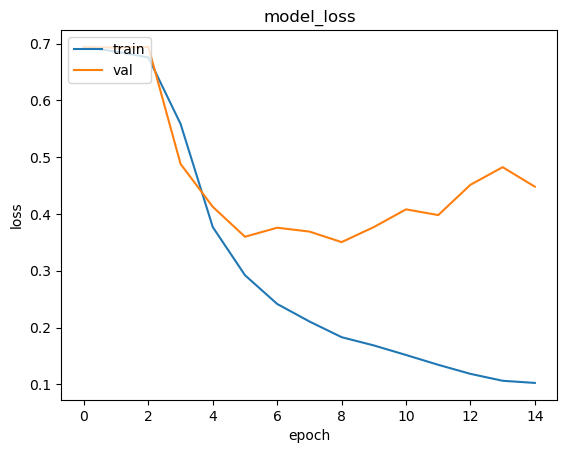

In [75]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

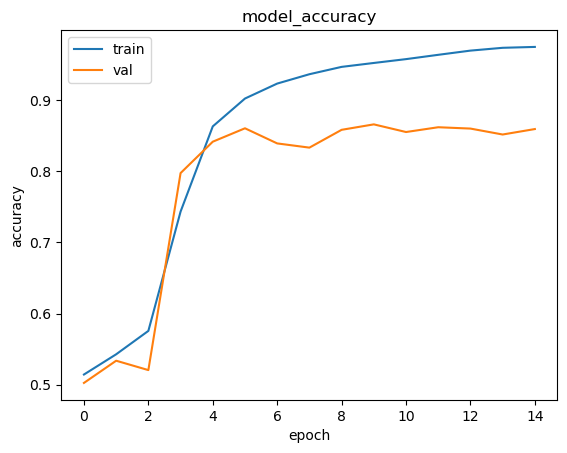

In [76]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### **Evaluate the model**

In [77]:
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

test_dataset=test_data.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model_simple_rnn.evaluate(test_dataset)

117/117 [==============================] - 2s 14ms/step - loss: 0.4300 - accuracy: 0.8629


[0.42998144030570984, 0.8628663420677185]

### **LSTM (MultiLayer and Bidirectional):**

#### **Build the model**

In [78]:
# 2. Early Stopping with Lower Patience: Reduce the patience parameter in the early stopping callback to prevent overfitting.
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=2,  # Number of epochs with no improvement after which training will be stopped
  restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Add More Data: If possible, augment the training dataset to provide more examples for the model to learn from. ??

In [79]:
# Define hyperparameters
# 1. Batch size for training and validation (64)
BATCH_SIZE=64
# 2. Maximum vocabulary size (10,000)
VOCAB_SIZE=10000
# 3. Maximum sequence length to pad the sentences to (250)
SEQUENCE_LENGTH=250
# 4. Embedding dimension (64)
EMBEDDING_DIM = 64

model_lstm =tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),
    Bidirectional(LSTM(64,return_sequences=True)),
    # 1. Increase Dropout Rate: To combat overfitting, consider increasing the dropout rate.
    Dropout(0.7),
    # 5.	Reduce Model Complexity: Simplify the model by reducing the number of LSTM units or layers to prevent overfitting.
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.7),
    # 4. Regularization Techniques: Implement L2 regularization to penalize large weights and prevent overfitting.
    Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))
])

model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 64)           640000    
                                                                 
 bidirectional (Bidirectiona  (None, 250, 128)         66048     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 250, 128)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)               

In [80]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath + "imdb_lstm_checkpoint.keras" ,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [81]:
# Mac M1/M2 happy with legacy: tf.keras.optimizers.legacy.Adam(1e-4)
model_lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer= tf.keras.optimizers.Adam(1e-4), #tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [82]:
# Model training
start_time = time.time()

print("Training the model...")


BATCH_SIZE=64

# Batch and prefetch the dataset
train_data = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

history=model_lstm.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    batch_size=BATCH_SIZE,
    callbacks=[model_checkpoint_callback, early_stopping])

model_lstm.save(saved_model_path + "imdb_lstm.keras")

end_time = time.time()

print("Time taken to train the model: ", end_time - start_time)

Training the model...
Epoch 1/15
543/543 [==============================] - ETA: 0s - loss: 0.6610 - accuracy: 0.5892WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000023029EE6560> and will run it as-is.
Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x0000023029EE6560>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x0000023029EE6560>. Note that functions defined in certain enviro

#### **Plot both training and validation metrics:**

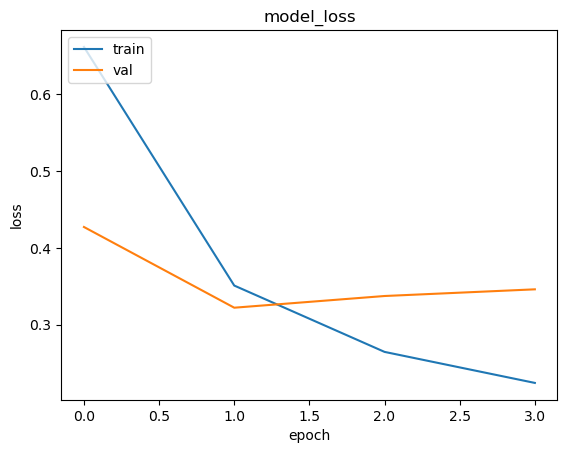

In [83]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

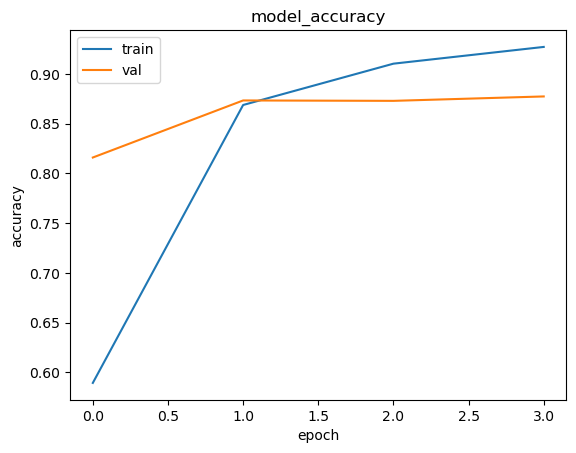

In [84]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### **Evaluate the model**

In [85]:
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

test_dataset=test_data.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model_lstm.evaluate(test_dataset)

117/117 [==============================] - 8s 69ms/step - loss: 0.3151 - accuracy: 0.8771


[0.31505218148231506, 0.8771175146102905]

### **Pretrained Word2Vec[Gensim]**

#### **Build the model**

In [86]:
# 2. Early Stopping with Lower Patience: Reduce the patience parameter in the early stopping callback to prevent overfitting.
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=2,  # Number of epochs with no improvement after which training will be stopped
  restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Add More Data: If possible, augment the training dataset to provide more examples for the model to learn from. ??

In [87]:
# import gensim.downloader as api
import gensim

# word2vec = api.load('word2vec-google-news-300')

# Load the model
word2vec = gensim.models.KeyedVectors.load_word2vec_format(embeddings + "GoogleNews-vectors-negative300.bin", binary=True)
# word2vec.vectors.shape

In [88]:
# Testing purpose
# print(word2vec.vocab)
word2vec['The']
# word2vec.most_similar('Man')
# word2vec.key_to_index

array([-0.17285156,  0.27929688,  0.10693359, -0.15820312, -0.08447266,
        0.05908203,  0.04077148,  0.00254822,  0.25976562,  0.18066406,
        0.09765625, -0.08105469, -0.01049805,  0.09814453,  0.00060272,
        0.07080078, -0.015625  , -0.09521484, -0.08105469, -0.02868652,
       -0.03320312,  0.16503906,  0.03979492, -0.03710938,  0.04101562,
       -0.12695312, -0.12890625,  0.12353516,  0.04980469,  0.01257324,
        0.05786133, -0.00830078, -0.02832031, -0.03320312,  0.16113281,
        0.07519531, -0.25976562,  0.08935547,  0.13574219,  0.00460815,
       -0.04418945,  0.02319336, -0.10449219, -0.05151367,  0.08349609,
       -0.02050781, -0.02172852, -0.02734375,  0.16015625,  0.19042969,
       -0.0324707 ,  0.06787109,  0.10302734, -0.25390625,  0.00634766,
        0.20507812,  0.02111816, -0.21679688, -0.02441406,  0.17089844,
       -0.21875   ,  0.10009766, -0.15527344, -0.12597656, -0.03833008,
       -0.05419922,  0.19238281,  0.21777344,  0.12109375, -0.02

In [89]:
def first_caps(word):
  return word[0].upper()+word[1:]

In [93]:
import numpy as np
import random

# Assuming vectorize_layer and word2vec are already defined
vectorize_layer_vocabulary = vectorize_layer.get_vocabulary()

# embedding_dim = pretrained_embeddings_array.shape[1]

# CUONG: fix pretrained_embeddings_array not defined
embedding_dim = len(word2vec[next(iter(word2vec.key_to_index))])
pretrained_embeddings = []

unfound_words = []
unfound_words_count = 0
found_words_count = 0

# Create dict from word2vec for faster search
word2vec_keys = set(word2vec.key_to_index.keys())

# Preallocate space for embeddings
pretrained_embeddings = np.zeros((len(vectorize_layer_vocabulary), embedding_dim))

# Fill the embeddings array
for i, word in enumerate(vectorize_layer_vocabulary):
    if word in word2vec_keys:
        found_words_count += 1
        pretrained_embeddings[i] = word2vec[word]
    else:
        unfound_words_count += 1
        unfound_words.append(word)
        pretrained_embeddings[i] = np.zeros(embedding_dim)  # Or use random.normal if preferred

    if i % 1000 == 0:
        print(f'Processed {i} words out of {len(vectorize_layer_vocabulary)}')

print(f"Found words count: {found_words_count}")
print(f"Unfound words count: {unfound_words_count}")
print(f"Pretrained embeddings shape: {pretrained_embeddings.shape}")

# Uncomment to print unfound words
# for word in unfound_words:
#     print(word)

Processed 0 words out of 10000
Processed 1000 words out of 10000
Processed 2000 words out of 10000
Processed 3000 words out of 10000
Processed 4000 words out of 10000
Processed 5000 words out of 10000
Processed 6000 words out of 10000
Processed 7000 words out of 10000
Processed 8000 words out of 10000
Processed 9000 words out of 10000
Found words count: 9520
Unfound words count: 480
Pretrained embeddings shape: (10000, 300)


In [94]:
# np.save("/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/embeddings/pretrained_embeddings", np.array(pretrained_embeddings))

np.save(embeddings + "pretrained_embeddings", np.array(pretrained_embeddings))

In [95]:
pretrained_embeddings_array=np.load(embeddings + "pretrained_embeddings.npy" )
pretrained_embeddings_array.shape[1]

300

In [102]:
from tensorflow.keras.layers import BatchNormalization
# from tensorflowkeras.regularizers import l2

# CUONG: fix regularizers not found
from keras.regularizers import l2


# Define hyperparameters
BATCH_SIZE = 64
VOCAB_SIZE = 10000
SEQUENCE_LENGTH = 250
EMBEDDING_DIM = pretrained_embeddings_array.shape[1]

# Build the model
lstm_pretrained_embedding_model = tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),

    Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        embeddings_initializer=tf.keras.initializers.Constant(pretrained_embeddings_array),
        trainable=True
    ),

    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))),
    Dropout(0.5),
    BatchNormalization(),

    Bidirectional(LSTM(32, kernel_regularizer=l2(0.01))),
    Dropout(0.5),
    BatchNormalization(),

    Dense(32, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid'),
])

# Display the model's architecture
lstm_pretrained_embedding_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 250, 300)          3000000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 250, 128)         186880    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 250, 128)          0         
                                                                 
 batch_normalization_2 (Batc  (None, 250, 128)         512       
 hNormalization)                                                 
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                      

In [103]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath + "imdb_lstm_word2vec_checkpoint.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [104]:
lstm_pretrained_embedding_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [105]:
# Model training
start_time = time.time()

print("Training the model...")

BATCH_SIZE=64

# Batch and prefetch the dataset
train_data = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

history=lstm_pretrained_embedding_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[model_checkpoint_callback, early_stopping])

lstm_pretrained_embedding_model.save(saved_model_path + "imdb_lstm_word2vec.keras")

end_time = time.time()

print("Time taken to train the model: ", end_time - start_time)

Training the model...
Epoch 1/10
543/543 [==============================] - ETA: 0s - loss: 6.2669 - accuracy: 0.5181WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002305E9F88B0> and will run it as-is.
Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x000002305E9F88B0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x000002305E9F88B0>. Note that functions defined in certain enviro

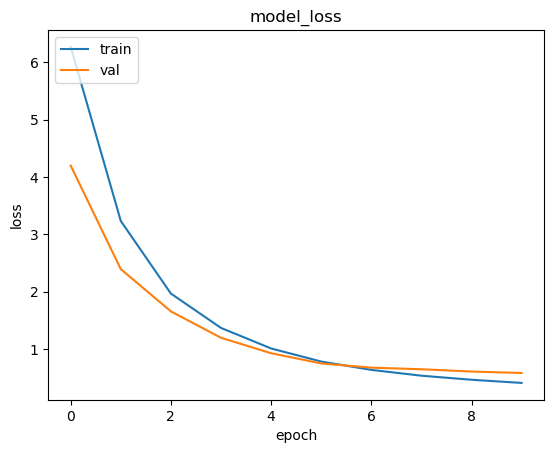

In [106]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

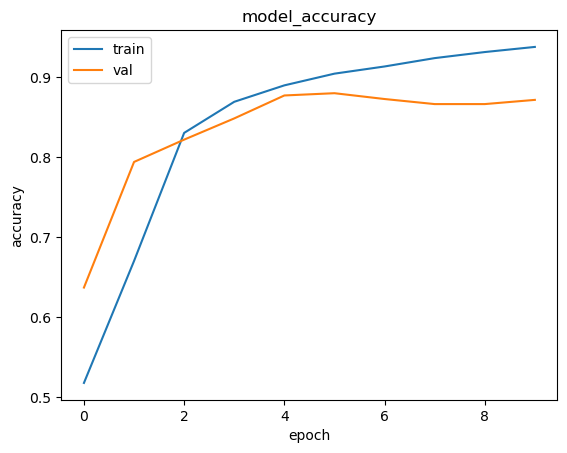

In [107]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### **Evaluate the model**

In [108]:
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

test_dataset=test_data.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
lstm_pretrained_embedding_model.evaluate(test_dataset)

117/117 [==============================] - 10s 85ms/step - loss: 0.5819 - accuracy: 0.8734


[0.5818579196929932, 0.8733530640602112]